# Example: measuring a LSF and path losses

This notebook demonstrates how to compute a line spread function for a Sersic profile. We'll also get path losses for free!  
We will assume a "standard" NIRSpec observing setup, i.e. we will open three shutters to form a slit, and use a 3-point dither.

Let's start by defining our model. We need to set up a configuration dictionary that will hold all the parameters that we need. We can create a dictionary with some default values (these are arbitrarily chosen!). We can then view the defaults and edit only the parameters that we care about.

In [12]:
from msafit.model.config import get_default_config

params = get_default_config()

# let's inspect the parameters
print(params.keys(),'\n')
print("params['morph']=", params["morph"])
print("\nparams['geometry']=", params["geometry"])

dict_keys(['geometry', 'instrument', 'morph', 'vfield', 'grid']) 

params['morph']= [{'profile': 'sersic', 'flux': 1.0, 'x0': 0.0, 'y0': 0.0, 'x0_sky': None, 'y0_sky': None, 'r_e': 0.3, 'n': 1.0, 'q': 0.6, 'PA': 90.0}]

params['geometry']= {'quadrant': 3, 'shutter_i': 183, 'shutter_j': 85, 'shutter_array': '1x3', 'source_shutter': 0, 'psky_x': 0.268, 'psky_y': 0.53}


To set up our morphological model, we need to change params["morph"]. This is a list of dictionaries (in this case, only one), as we can in principle add multiple morphological components. 

We'll change these parameters so that the flux of our Sersic profile integrates to 1 (you'll see why later) and give the source some offset within the shutter. Note that x0 and y0 here are in units of **pitch**, not arcsec, and defined with respect to the centre of the source shutter (not necessarily the middle shutter!). If you want to define your shutter offset in arcsec, you will need to set "x0_sky" and "y0_sky" keywords. Finally, let's also change the size, Sersic index and axis ratio for fun.

We will use the default parameters in params["geometry"]: this describes the quadrant, shutter (i,j), and the shutter configuration. I.e. 1x3 shutters in our case in quadrant 3, (i=183,j=85), and we will assume the object is in the middle shutter of these 3: source_shutter = 0. The parameters psky_x and psky_y describe the plate scale, the default values are the average of all shutters from Ferruit et al. (2022).

In [23]:
params["morph"][0]["profile"] = "sersic"  # specify the profile
params["morph"][0]["flux"] = 1.           # integrated flux of the Sersic profile
params["morph"][0]["x0"] = 0.0            # offset in dispersion direction (pitch, not arcsec)
params["morph"][0]["y0"] = 0.2            # offset in cross-dispersion direction (pitch, not arcsec)
params["morph"][0]["r_e"] = 0.3           # this is in arcsec
params["morph"][0]["n"] = 1.5             # Sersic index
params["morph"][0]["q"] = 0.4             # axis ratio
params["morph"][0]["PA"] = 90             # rotation angle wrt positive x-axis 
                                          # (note: differs from e.g. the galfit default)

We can now construct our model. As we only want to know the effect of the light profile on the LSF, we will use a model from the MorphOnly set of models. The options are Point, Sersic, Gauss, and UniformIllum. We want a Sersic profile, so we take the Sersic model class.

The model is evaluated for some wavelength grid. We also place this wavelength grid in our parameter dict.

In [24]:
import numpy as np
from msafit.model import Sersic


wave_grid = np.arange(1.7,3.3,0.1)*1e4    # this needs to be in AA
params["grid"]["wave_grid"] = wave_grid

# create a model cube I(x,y,lambda)
model = Sersic(params)
model.compute(wave_grid)


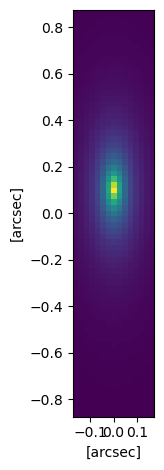

total flux 0.8211974823298771


In [26]:
# now plot a slice of the cube

import matplotlib.pyplot as plt

extent = [np.min(params["grid"]["x_grid_sky"]),np.max(params["grid"]["x_grid_sky"]),
         np.min(params["grid"]["y_grid_sky"]),np.max(params["grid"]["y_grid_sky"])]
plt.imshow(model.data[0],origin='lower',extent=extent)
plt.xlabel('[arcsec]')
plt.ylabel('[arcsec]')
plt.tight_layout()
plt.show()

print('total flux', np.sum(model.data[0]))


Next, we need to convolve our model with the NIRSpec PSF. We can read in a pre-existing library to do so.

We'll choose the F170LP/G235M filter/disperser combination. Our library holds PSFs that are oversampled by a factor 5.

In [16]:
from msafit.fpa.psf import PSFLib
import os

filt = "F170LP"
disp = "G235M"

params["instrument"]["filter"] = "F170LP"
params["instrument"]["disperser"] = "G235M"
params["instrument"]["psf_oversampling"] = 5

psf_path = os.path.expandvars("${msa_refdata}")+f"/psf/psf_libs/1x3_{filt}_{disp}_3_183_85_PSFlib.fits"
psf_lib = PSFLib(fname=psf_path)



We now have all the ingredients to put our source on the detector. If we set return_fluxes=True we will also measure the total flux on the detector per wavelength slice. Because we set our total flux=1 this means we directly get the throughput (or, 1-path_losses).

As expected, the throughput decreases with wavelength.

In [27]:
from msafit.fpa import Spec2D

spec = Spec2D(params,pad_y=10)
throughput = spec.make_spec2d(model,psf_lib,wave_thresh=1e2,return_fluxes=True,rotate_slit=False)

print("\ntotal flux on detector:",throughput)



total flux on detector: [0.42703186 0.42383115 0.42050969 0.41708361 0.41353224 0.40986942
 0.40615109 0.40243841 0.39874071 0.39502803 0.39128488 0.38751324
 0.38371783 0.37990651 0.37607284 0.37221253]


Some warnings were printed to inform us of wavelengths that fall in the chip gap. 

We can now plot the detectors, and zoom in on some of the individual emission lines.


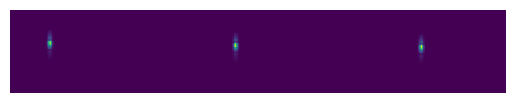

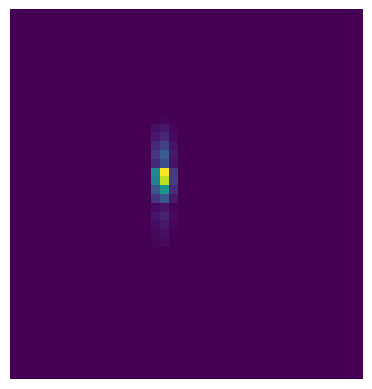

In [18]:
# let's plot some of detector SCA-491 

plt.imshow(spec.spec_491[:,0:250],origin='lower')
plt.axis('off')
plt.show()

plt.imshow(spec.spec_491[:,190:230],origin='lower')
plt.axis('off')
plt.show()

We can now repeat this for the other two dithers, and then collapse our set of spectra to compute the LSF. The latter steps are all handled in the LSF class. (Note that any 1D spectra created in the process are **not** real 1D spectra, as there is no wavelength calibration nor regridding)

In [10]:
from msafit.lsf import LSF
from copy import deepcopy

params_2 = deepcopy(params)
params_2["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] - 1
params_2["geometry"]["source_shutter"] = -1
spec_2 = Spec2D(params_2,pad_y=10)
spec_2.make_spec2d(model,psf_lib,rotate_slit=False)
    
params_3 = deepcopy(params)
params_3["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] + 1
params_3["geometry"]["source_shutter"] = 1
spec_3 = Spec2D(params_3,pad_y=10)
spec_3.make_spec2d(model,psf_lib,rotate_slit=False)

# we provide our 3 dithers to the LSF class
# we only provide the wavelengths of interest and corresponding x FPA coordinates once
lsf = LSF([spec,spec_2,spec_3],spec.wl_fpa,spec.x_fpa)
fit_output = lsf.compute_lsf()

The fit_output can be used for plotting. More important is that we can now estimate the LSF anywhere! (at least, anywhere within the wavelength range we defined earlier)

In [11]:
print('resolution at 2.52 micron =', lsf.resolution(2.52e4))
print('dispersion at 1.78 micron =', lsf.dispersion_kms(1.78e4), 'km/s')


resolution at 2.52 micron = 1554.5091674941975
dispersion at 1.78 micron = 118.005066390039 km/s


In [ ]:
from msafit.lsf.fit_func import gauss_dataset
from matplotlib.ticker import AutoMinorLocator

x1d,spec1d = spec.to_1d()

model_1d = gauss_dataset(fit_output[0].params,0,len(lsf.wl_fpa),x1d)


fig,ax = plt.subplots(1,1,figsize=(10,3.5))

ax.plot(x1d,spec1d,color='k',ls='solid',label='spectrum')
ax.plot(x1d,model_1d,color='C1',ls='--',label='LSF model')
ax.set_xlabel(r"detector x [m]",fontsize=12)
ax.set_ylabel(r"flux",fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())		
ax.tick_params(direction='in',which='both',top=True,right=True)
ax.locator_params(nbins=6)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(x1d[100:130],spec1d[100:130],color='k',ls='solid',label='spectrum')
ax.plot(x1d[100:130],model_1d[100:130],color='C1',ls='--',label='LSF model')
ax.set_xlabel(r"detector x [m]",fontsize=12)
ax.set_ylabel(r"flux",fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())		
ax.tick_params(direction='in',which='both',top=True,right=True)
ax.locator_params(nbins=6)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

Finally, let's compare with what STScI tells us... (https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters)

Quite different!

In [ ]:
from astropy.table import Table
from scipy.interpolate import interp1d

disp_curve_stsci = Table.read(f'./data/jwst_nirspec_{disp.lower()}_disp.fits')
fdisp = interp1d(disp_curve_stsci['WAVELENGTH'],disp_curve_stsci['R'],kind='cubic')
wrange = np.arange(1.7,3.1,0.025)*1e4

fig,ax = plt.subplots(1,2,figsize=(7,3.3))

ax[0].plot(wrange*1e-4,lsf.resolution(wrange),color='C0',ls='--',label='point source')
ax[0].plot(wrange*1e-4,fdisp(wrange*1e-4),color='k',ls='solid',label='nominal resolution')
ax[0].set_xlabel(r"wavelength [micron]",fontsize=12)
ax[0].set_ylabel(r"resolution",fontsize=12)
ax[0].set_ylim(500,2500)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())		
ax[0].tick_params(direction='in',which='both',top=True,right=True)
ax[0].locator_params(nbins=6)


ax[1].plot(wrange*1e-4,2*np.sqrt(2*np.log(2)) *lsf.dispersion_kms(wrange),color='C0',ls='--',label='point source')
ax[1].plot(wrange*1e-4,3e5/(fdisp(wrange*1e-4)),color='k',ls='solid',label='nominal resolution')
ax[1].set_xlabel(r"wavelength [micron]",fontsize=12)
ax[1].set_ylabel(r"FWHM [$\rm km\,s^{-1}$]",fontsize=12)
ax[1].set_ylim(125,450)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())		
ax[1].tick_params(direction='in',which='both',top=True,right=True)
ax[1].locator_params(nbins=6)
ax[1].legend(fontsize=9)

plt.tight_layout()
plt.show()